This bot operates using the same strategy as the TripleSMACrossoverLongbot. However, it can take both short and long positions.

### Impleneting a long short backtester for the Triple SMA crossover strategy

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn")

In [53]:
class Long_Short_Backtester():
    ''' Class for the vectorized backtesting of simple Long-Short trading strategies.
    
    Attributes
    ============
    filepath: str
        local filepath of the dataset (csv-file)
    symbol: str
        ticker symbol (instrument) to be backtested
    start: str
        start date for data import
    end: str
        end date for data import
    tc: float
        proportional trading costs per trade
    
    
    Methods
    =======
    get_data:
        imports the data.
        
    test_strategy:
        prepares the data and backtests the trading strategy incl. reporting (wrapper).
        
    prepare_data:
        prepares the data for backtesting.
    
    run_backtest:
        runs the strategy backtest.
        
    plot_results:
        plots the cumulative performance of the trading strategy compared to buy-and-hold.
        
    optimize_strategy:
        backtests strategy for different parameter values incl. optimization and reporting (wrapper).
    
    find_best_strategy:
        finds the optimal strategy (global maximum).
         
        
    print_performance:
        calculates and prints various performance metrics.
        
    '''    
    
    def __init__(self, filepath, symbol, start, end, tc):
        
        self.filepath = filepath
        self.symbol = symbol
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None
        self.get_data()
        self.tp_year = (self.data.Close.count() / ((self.data.index[-1] - self.data.index[0]).days / 365.25))
        
    def __repr__(self):
        return "Long_Short_Backtester(symbol = {}, start = {}, end = {})".format(self.symbol, self.start, self.end)
        
    def get_data(self):
        ''' Imports the data.
        '''
        raw = pd.read_csv(self.filepath, parse_dates = ["Date"], index_col = "Date")
        raw = raw.loc[self.start:self.end].copy()
        raw["returns"] = np.log(raw.Close / raw.Close.shift(1))
        self.data = raw
        
    def test_strategy(self, smas):
        '''
        Prepares the data and backtests the trading strategy incl. reporting (Wrapper).
         
        Parameters
        ============
        smas: tuple (SMA_S, SMA_M, SMA_L)
            Simple Moving Averages to be considered for the strategy.
            
        '''
        
        self.SMA_S = smas[0]
        self.SMA_M = smas[1]
        self.SMA_L = smas[2]
        
        
        self.prepare_data(smas = smas)
        self.run_backtest()
        
        data = self.results.copy()
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        
        self.print_performance()
    
    def prepare_data(self, smas):
        ''' Prepares the Data for Backtesting.
        '''
        ########################## Strategy-Specific #############################
        
        data = self.data[["Close", "returns"]].copy()
        data["SMA_S"] = data.Close.rolling(window = smas[0]).mean()
        data["SMA_M"] = data.Close.rolling(window = smas[1]).mean()
        data["SMA_L"] = data.Close.rolling(window = smas[2]).mean()
        
        data.dropna(inplace = True)
                
        cond1 = (data.SMA_S > data.SMA_M) & (data.SMA_M > data.SMA_L)
        cond2 = (data.SMA_S < data.SMA_M) & (data.SMA_M < data.SMA_L)
        
        data["position"] = 0
        data.loc[cond1, "position"] = 1
        data.loc[cond2, "position"] = -1

        ##########################################################################
        
        self.results = data
    
    def run_backtest(self):
        ''' Runs the strategy backtest.
        '''
        
        data = self.results.copy()
        data["strategy"] = data["position"].shift(1) * data["returns"]
        data["trades"] = data.position.diff().fillna(0).abs()
        data.strategy = data.strategy + data.trades * self.tc
        
        self.results = data
    
    def plot_results(self):
        '''  Plots the cumulative performance of the trading strategy compared to buy-and-hold.
        '''
        if self.results is None:
            print("Run test_strategy() first.")
        else:
            title = "{} | TC = {}".format(self.symbol, self.tc)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))
            plt.legend(["Buy and Hold multiple", "Strategy multiple"])
            
    def optimize_strategy(self, SMA_S_range, SMA_M_range, SMA_L_range, metric = "Multiple"):
        '''
        Backtests strategy for different parameter values incl. Optimization and Reporting (Wrapper).
         
        Parameters
        ============
        SMA_S_range: tuple
            tuples of the form (start, end, step size).
        
        SMA_M_range: tuple
            tuples of the form (start, end, step size).
            
        SMA_L_range: tuple
            tuples of the form (start, end, step size).
        
        metric: str
            performance metric to be optimized (can be "Multiple" or "Sharpe")
        '''
        
        self.metric = metric
        
        if metric == "Multiple":
            performance_function = self.calculate_multiple
        elif metric == "Sharpe":
            performance_function = self.calculate_sharpe
        
        SMA_S_range = range(*SMA_S_range)
        SMA_M_range = range(*SMA_M_range)
        SMA_L_range = range(*SMA_L_range)
        
        combinations = list(product(SMA_S_range, SMA_M_range, SMA_L_range))
         
        performance = []
        for comb in combinations:
            self.prepare_data(smas = comb)
            self.run_backtest()
            performance.append(performance_function(self.results.strategy))
    
        self.results_overview =  pd.DataFrame(data = np.array(combinations), columns = ["SMA_S", "SMA_M", "SMA_L"])
        self.results_overview["performance"] = performance
        self.find_best_strategy()
        
        
    def find_best_strategy(self):
        ''' Finds the optimal strategy (global maximum).
        '''
        
        best = self.results_overview.nlargest(1, "performance")
        SMA_S = best.SMA_S.iloc[0]
        SMA_M = best.SMA_M.iloc[0]
        SMA_L = best.SMA_L.iloc[0]
        perf = best.performance.iloc[0]
        print("SMA_S: {} | SMA_M: {} | SMA_L : {} | {}: {}".format(SMA_S, SMA_M, SMA_L, self.metric, round(perf, 5)))  
        self.test_strategy(smas = (SMA_S, SMA_M, SMA_L))
            
    ############################## Performance ######################################
    
    def print_performance(self):
        ''' Calculates and prints various Performance Metrics.
        '''
        
        data = self.results.copy()
        strategy_multiple = round(self.calculate_multiple(data.strategy), 6)
        bh_multiple =       round(self.calculate_multiple(data.returns), 6)
        outperf =           round(strategy_multiple - bh_multiple, 6)
        cagr =              round(self.calculate_cagr(data.strategy), 6)
        ann_mean =          round(self.calculate_annualized_mean(data.strategy), 6)
        ann_std =           round(self.calculate_annualized_std(data.strategy), 6)
        sharpe =            round(self.calculate_sharpe(data.strategy), 6)
       
        print(100 * "=")
        print("TRIPLE SMA STRATEGY | INSTRUMENT = {} | SMAs = {}".format(self.symbol, [self.SMA_S, self.SMA_M, self.SMA_L]))
        print(100 * "-")
        print("PERFORMANCE MEASURES:")
        print("\n")
        print("Multiple (Strategy):         {}".format(strategy_multiple))
        print("Multiple (Buy-and-Hold):     {}".format(bh_multiple))
        print(38 * "-")
        print("Out-/Underperformance:       {}".format(outperf))
        print("\n")
        print("CAGR:                        {}".format(cagr))
        print("Annualized Mean:             {}".format(ann_mean))
        print("Annualized Std:              {}".format(ann_std))
        print("Sharpe Ratio:                {}".format(sharpe))
        
        print(100 * "=")
        
    def calculate_multiple(self, series):
        return np.exp(series.sum())
    
    def calculate_cagr(self, series):
        return np.exp(series.sum())**(1/((series.index[-1] - series.index[0]).days / 365.25)) - 1
    
    def calculate_annualized_mean(self, series):
        return series.mean() * self.tp_year
    
    def calculate_annualized_std(self, series):
        return series.std() * np.sqrt(self.tp_year)
    
    def calculate_sharpe(self, series):
        if series.std() == 0:
            return np.nan
        else:
            return self.calculate_cagr(series) / self.calculate_annualized_std(series)

In [54]:
filepath = "bitcoin.csv"
symbol = "BTCUSDT"
start = "2017-08-17"
end = "2020-11-25"
tc = -0.00075
sma_s = 15 
sma_m = 50 
sma_l = 200 

In [55]:
tester = Long_Short_Backtester(filepath = filepath, symbol = symbol,
                              start = start, end = end, tc = tc)
tester.test_strategy(smas = (sma_s, sma_m, sma_l))

TRIPLE SMA STRATEGY | INSTRUMENT = BTCUSDT | SMAs = [15, 50, 200]
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         1.340105
Multiple (Buy-and-Hold):     1.632792
--------------------------------------
Out-/Underperformance:       -0.292687


CAGR:                        0.11321
Annualized Mean:             0.107338
Annualized Std:              0.535785
Sharpe Ratio:                0.211298


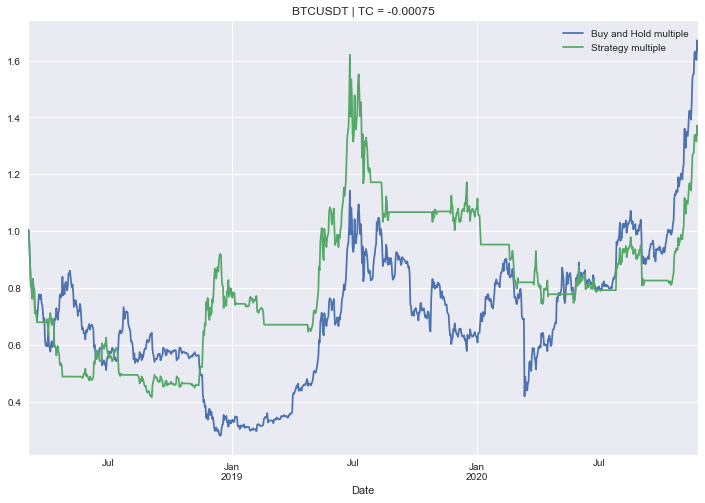

In [56]:
tester.plot_results()

As we see, the triple SMA crossover (long and short) is performing worse than the simple buy and hold strategy. However, let's see how it works after we optimize it.

### Optimization

In [57]:
from itertools import product
import warnings
warnings.filterwarnings("ignore")

In [58]:
tester.optimize_strategy(SMA_S_range = (5, 60, 5), 
                         SMA_M_range = (70, 150, 5),
                         SMA_L_range = (150, 300, 10))

SMA_S: 40 | SMA_M: 115 | SMA_L : 170 | Multiple: 8.37608
TRIPLE SMA STRATEGY | INSTRUMENT = BTCUSDT | SMAs = [40, 115, 170]
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         8.37608
Multiple (Buy-and-Hold):     2.029277
--------------------------------------
Out-/Underperformance:       6.346803


CAGR:                        1.129498
Annualized Mean:             0.756518
Annualized Std:              0.576353
Sharpe Ratio:                1.959733


Now the results are better. Note, that the buy and hold multiple is different then the earlier multiple. This due to the fact, that SMA(n) can be calculated only after n days have passed. Thus, the multiple is different because we took a different time period.

### Now let's take a look how each of the steps in our parameters effected the bot performance

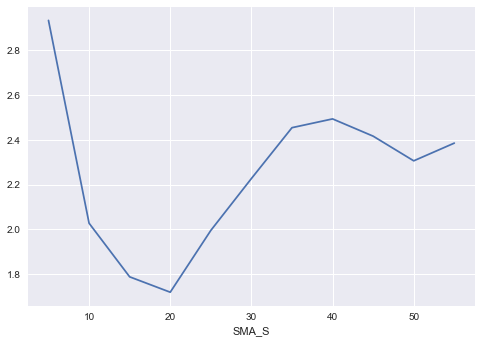

In [59]:
results = tester.results_overview
results.groupby("SMA_S").performance.mean().plot()
plt.show()

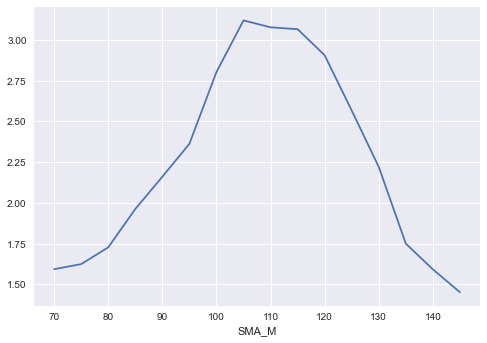

In [60]:
results = tester.results_overview
results.groupby("SMA_M").performance.mean().plot()
plt.show()

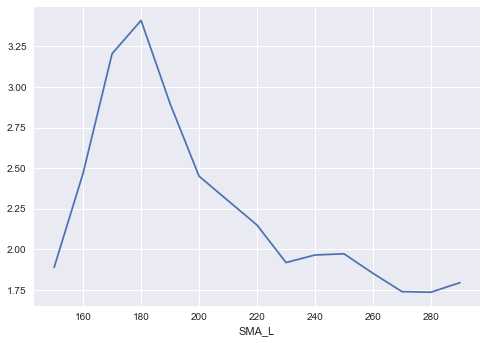

In [61]:
results = tester.results_overview
results.groupby("SMA_L").performance.mean().plot()
plt.show()

As we see from the plots, it is best to take a 40 day small SMA, a 110 day medium SMA, and a 175 day large SMA

In [64]:
tester.test_strategy(smas = (40, 110, 175))

TRIPLE SMA STRATEGY | INSTRUMENT = BTCUSDT | SMAs = [40, 110, 175]
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         7.72798
Multiple (Buy-and-Hold):     2.446258
--------------------------------------
Out-/Underperformance:       5.281722


CAGR:                        1.076747
Annualized Mean:             0.731414
Annualized Std:              0.553975
Sharpe Ratio:                1.943675


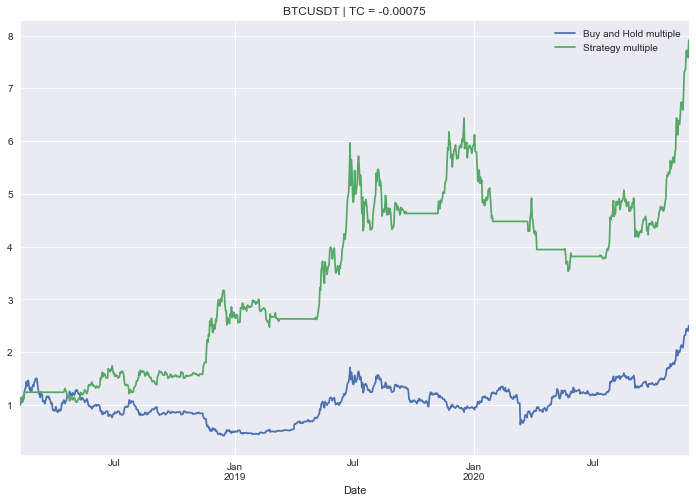

In [65]:
tester.plot_results()

As we see, now our strategy is performing even better. However, let's see whether it performs better than the simple buy and hold strategy in the forward test

### Forward testing

Here we will take the start date as 2020-06-04 because the values for the first 176 days will be missing, as it is impossible to calculate the 175 day SMA until 175 days haven't passed

In [67]:
filepath = "bitcoin.csv"
symbol = "BTCUSDT"
start = "2020-06-04"
end = "2021-12-31"
tc = -0.00075

In [68]:
tester = Long_Short_Backtester(filepath = filepath, symbol = symbol,
                              start = start, end = end, tc = tc)
tester.test_strategy(smas = (40, 110, 175))

TRIPLE SMA STRATEGY | INSTRUMENT = BTCUSDT | SMAs = [40, 110, 175]
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         1.072347
Multiple (Buy-and-Hold):     2.412156
--------------------------------------
Out-/Underperformance:       -1.339809


CAGR:                        0.06569
Annualized Mean:             0.063733
Annualized Std:              0.687427
Sharpe Ratio:                0.09556


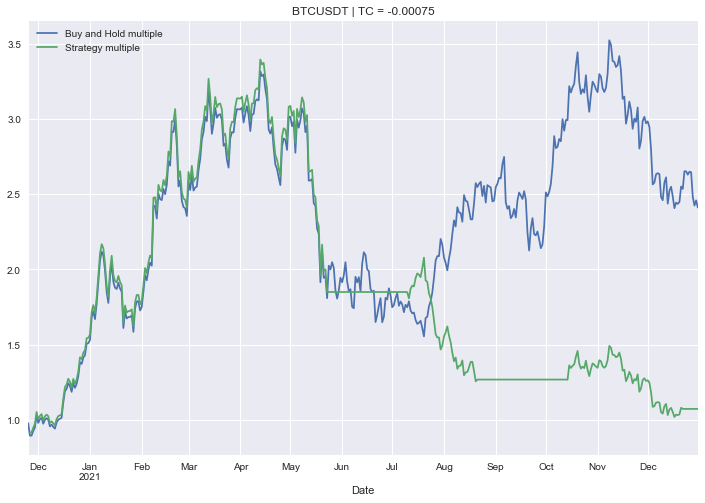

In [69]:
tester.plot_results()

Unfortunately, our strategy is underperforming in the forward test. Therefore, we cannot consider it to be valuable. Thus, let's try our final strategy, which will be a combination of different signals in the Bollinger Bands, Relative strength index, and Moving Average Convergance/Divergance

## Position distribution

In [70]:
tester.results.position.value_counts()

 1    248
 0    112
-1     42
Name: position, dtype: int64

As we see, we took a neutral and short position pretty regularly and we probably took it more than needed which is why this strategy is underperforming in the forward test